# Chapter 13: Loading and Preprocessing Data with TensorFlow

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Since Deep Learning systems are often trained on very large datasets that will not fit in RAM, TensorFlow's **Data API** solves this issue by taking care of all the implementation details and only needs:
- A dataset object
- Where to get the data
- How to transform it

## 13.1 The Data API

The Data API revolves around the concept of a **dataset**: a sequence of data items.

In [ ]:
# Create a dataset entirely in RAM
X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The `from_tensor_slices()` function takes a tensor and creates a `tf.data.Dataset` whose elements are all the slices of X. This is the same as `tf.data.Dataset.range(10)`.

In [ ]:
# Iterate over dataset's items
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### 13.1.1 Chaining Transformations

Once you have a dataset, you can apply transformations by calling its transformation methods.

In [ ]:
# See Figure 13-1. Chaining dataset transformations
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


With original dataset,
1. Call `repeat(3)` to return a new dataset with 3 copies of the dataset.
    - Calling with no arguments will result in a new dataset that repeats forever, so the code that iterates over the dataset must decide when to stop.

2. Call `batch(7)` to return a new dataset that groups the items into batches of 7 items and any remaining items in the last batch (batch of 2).
    - Add `drop_remainder=True` argument to drop this final batch.

> Note: Dataset methods **do not** modify datasets; they create new ones (ie. assign with `dataset = ...`) or else nothing will happen.

In [ ]:
# Creates new dataset with all items doubled
dataset = dataset.map(lambda x: x * 2) # Items:[0,2,4,6,8,10,12]
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


While the `map()` method applies a transformation to each item, the `apply()` method applies a transformation to the dataset as a whole.

> Note: `apply()` method is not used since `tf.data.Dataset.unbatch(dataset)` needs 1 argument for the dataset.

In [ ]:
# tf.data.experimental.unbatch() is now deprecated
# Use tf.data.Dataset.unbatch()
# Each item in the new dataset will be single-integer tensor
dataset = tf.data.Dataset.unbatch(dataset)

# Filter the dataset
dataset = dataset.filter(lambda x: x < 10) # Items: 0 2 4 6 8 0 2 4 6...

# Look at just a few items from dataset
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### 13.1.2 Shuffling the Data

Gradient Descent works best when the instances in the training set are independent and identically distributed (iid). A simple way to ensure this is to shuffle the instances, using the `shuffle()` method.

> Note: You must specify the buffer size, and it's important to make it large enough, or else shuffling will not be very effective.

> Note: By default, calling `repeat()` on a shuffled dataset will generate a new order at every iteration.

In [ ]:
dataset = tf.data.Dataset.range(10).repeat(3) # 0 to 9, three times
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


For large datasets, simple shuffling-buffer may not be enough; buffer size is still small compared to the large dataset.

Some solutions are:
- Shuffle the source data itself.
- Split the source data into multiple files, then read them in a random order during training.
- Pick multiple files randomly and read them simultaneously, interleaving their records.
- Add a shuffling buffer on top of all that using `shuffle()` method.

#### Interleaving lines from multiple files

In [ ]:
# FROM TEXTBOOK NOTEBOOK
# Load CA housing dataset
# Split into training, validation, test set
# Scale sets

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [ ]:
# FROM TEXTBOOK NOTEBOOK
# Split housing set
# Save into 20 CSV files

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [ ]:
# FROM TEXTBOOK NOTEBOOK
# Read 1st few lines of CSV file in text mode

with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [ ]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [ ]:
# Create dataset with only these file paths
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

> Note: By default, the `list_files()` function returns a dataset that shuffles the file paths.

Next, call `interleave()` method to read from five files at a time and interleave their lines (skipping 1st line which is the header row).

In [ ]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

At this stage, there will be 7 datasets in all:
- The filepath dataset
- The interleave dataset
- 5 `TextLineDatasets` created internally by the interleave dataset.

When iterating over the interleave set, it will cycle through these 5 `TextLineDatasets` reading one line at a time until all datasets are out of items. Then it will get the next 5 file paths from `filepath_dataset` and interleave them the same way until it runs out of file paths.

By default, `interleave()` does not use parallelism; it just reads one line at a time from each file. To read files in parallel, set `num_parallel_calls` argument to the number of threads you want.

In [ ]:
# 1st rows of 5 CSV files, chosen randomly

for line in dataset.take(5):
    print(line.numpy())

b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'


### 13.1.3 Preprocessing the Data

In [ ]:
# X_mean, X_std = # mean and scale of each feature in the training set
# X_mean, X_std already assigned when loading CA dataset

n_inputs = 8

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

Code explanation:

1. (Line 1): Precomputed the mean and standard deviation of each feature in the training set.

2. (Lines 6-8): The `preprocess()` function takes one CSV line and starts by parsing it.
    - (Line 7): All feature columns are floats and missing values should default to 0. And provide an empty array of type `tf.float32` as the default value for the last column (the target).
    - (Line 8): `tf.io.decode_csv()` function takes 2 arguments: the line to parse and an array containing the default value for each column in the CSV file.

3. (Lines 9-10): `decode_csv()` function returns a list of scalar tensors (1 per column) but we need to return 1D tensor arrays.
    - (Line 9): Call `tf.stack()` on all tensors except last one (the target) to stack tensors into a 1D array.
    - (Line 10): Call `tf.stack()` on target value to stack into a 1D tensor array with a single value, rather than a scalar tensor.

4. (Line 11): Scale the input features by subtracting the feature means `(x - X_mean)`, dividing by the feature standard deviation `/ X_std`, and return a tuple containing the scaled features and the target.


In [ ]:
# Test preprocessing function
preprocess(b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204396, -0.39210168, -0.5277444 ,
        -0.26334172,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### 13.1.4 Putting Everything Together

Put everything together into a small helper function that will:
- Create and return a dataset that will load CA housing data from multiple CSV files
- Preprocess it
- Shuffle it
- Optionally repeat it
- Batch it

In [ ]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths) # Create dataset from multiple CSV files
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads) # Calls preprocess function
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat) # Shuffles dataset "repeat" times
    return dataset.batch(batch_size).prefetch(1) # Important for performance

### 13.1.5 Prefetching

By calling `prefetch(1)` at the end, we are creating a dataset that will do its best to always be 1 (or multiple) batch(es) ahead. 

In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (eg. reading the data from disk and preprocessing it).

> Note: With prefetching, the CPU and GPU work in parallel: as the GPU works on one batch, the CPU works on the next.

If the dataset is small enough to fit in memory, use dataset's `cache()` method to cache its content to RAM and speed up training. Do this **after** loading and preprocessing the data, but **before** shuffling, repeating, batching, and prefetching.

### 13.1.6 Using the Dataset with tf.keras

In [ ]:
# Use csv_reader_dataset() to create sets
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [ ]:
# From textbook notebook
# Build and train Keras model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 3.0959 - val_loss: 3.8690
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 1.0523 - val_loss: 1.1137
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8122 - val_loss: 0.7239
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7343 - val_loss: 0.6612
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6527 - val_loss: 0.6517
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6341 - val_loss: 0.6310
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6299 - val_loss: 0.6054
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5916 - val_loss: 0.5891
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5682 - val_loss: 0.5564
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5330 - val_loss: 0.5215

In [ ]:
# Evaluate on test set and make prediction
model.evaluate(test_set)
new_set = test_set.take(3).map(lambda X, y: X) # pretend we have 3 new instances
model.predict(new_set) # a dataset containing new instances

162/162 [==============================] - 0s 1ms/step - loss: 0.5228


array([[2.3385925 ],
       [1.3566871 ],
       [1.975553  ],
       [1.1848876 ],
       [1.5380412 ],
       [2.5135336 ],
       [2.2623162 ],
       [1.2559526 ],
       [2.6903954 ],
       [2.714336  ],
       [1.8362496 ],
       [2.0574398 ],
       [1.942119  ],
       [2.411251  ],
       [1.0365776 ],
       [0.78242517],
       [1.3213642 ],
       [2.1210408 ],
       [1.818429  ],
       [2.685921  ],
       [1.5517488 ],
       [2.303208  ],
       [2.1002278 ],
       [1.8787147 ],
       [1.8928831 ],
       [2.6535788 ],
       [2.1432931 ],
       [1.6555791 ],
       [2.926011  ],
       [3.245479  ],
       [1.0477158 ],
       [0.85796463],
       [1.278811  ],
       [1.5953363 ],
       [1.6979065 ],
       [3.4787908 ],
       [1.5887406 ],
       [2.496935  ],
       [3.0445418 ],
       [2.0707269 ],
       [2.5267224 ],
       [2.5330534 ],
       [3.4804492 ],
       [0.77085966],
       [3.8585725 ],
       [1.5676365 ],
       [3.6967864 ],
       [1.776

In [ ]:
# FROM TEXTBOOK NOTEBOOK

# To build custom training loop,
# iterate over the training set
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

global_step = 0
for X_batch, y_batch in train_set:
    global_step += 1
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
# FROM TEXTBOOK NOTEBOOK

# TF Function that performs the whole training loop
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

## 13.2 The TFRecord Format

The TFRecord format is TensorFlow's preferred format for storing large amounts of data and reading it efficiently.

In [ ]:
# Create a TFRecord file
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [ ]:
# Read TFRecord file
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### 13.2.1 Compressed TFRecord Files

To create a compressed TFRecord file, set the options argument.

In [ ]:
# Create a compressed TFRecord file
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [ ]:
# Read a compressed TFRecord file
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### 13.2.2 A Brief Introduction to Protocol Buffers

TFRecord files usually contain serialized **protocol buffers** (also called **protobufs**). This is a portable, extensible, and efficient binary format developed at Google.

In [ ]:
# protobuf defined that looks like
# from textbook notebook 
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Writing person.proto


Definition explanation:

1. (Line 3): We are using version 3 of the protobuf format

2. (Line 4): Protobuf objects are meant to be serialized and transmitted, therefore are called *messages*.

3. (Lines 5-7): The "contents" of the protobuf object
    - The numbers `1, 2, 3` are the field identifiers: they will be used in each record's binary representation.

In [ ]:
# FROM TEXTBOOK NOTEBOOK
!protoc person.proto --python_out=. # importing protobuf compiler

In [ ]:
# Using access classes generated for Person protobuf
from person_pb2 import Person # import the generated access class

In [ ]:
person = Person(name="Al", id=123, email=["a@b.com"]) # create a Person
print(person) # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [ ]:
person.name # read a field

'Al'

In [ ]:
person.name = "Alice" # modify a field
person.email[0] # repeated fields can be accessed like arrays

'a@b.com'

In [ ]:
person.email.append("c@d.com") # add an email address
s = person.SerializeToString() # serialize the object to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [ ]:
person2 = Person() # create a new Person
person2.ParseFromString(s) # parse the byte string (27 bytes long)

27

In [ ]:
person == person2 # now they are equal

True

To summarize,
1. Import `Person` class generated by protoc.
2. Create an instance and visualize it, read/write some fields.
3. Serialize it using `SerializeToString()` method.
4. To read and parse the binary data, use `ParseFromString()` method.
5. Returns a copy of the object that was serialized.

> Note: Since these operations are not TensorFlow operations, they cannot be included in a TensorFlow Function.

### 13.2.3 TensorFlow Protobufs

The main protobuf typically used in a TFRecord file is the `Example` protobuf, which represents one instance in a dataset.

In [ ]:
# Example protobuf definition
# %%writefile so no error
%%writefile Example.proto
syntax = "proto3";
message BytesList { repeated bytes value = 1;}
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };

Writing Example.proto


Definition explanation:

- (Lines 6 & 7): `[packed = true]` is used for repeated numerical fields, for a more efficient encoding.

- (Lines 8-14): A `Feature` contains either a `BytesList`, a `FloatList`, or an `Int64List`.

- (Line 15): A `Features` contains a **dictionary** that maps a feature name to the corresponding feature value.

- (Line 16): An `Example` only contains a `Features` object.

In [ ]:
"""Create a tf.train.Example
representing the same person as earlier
and write it to a TFRecord file."""
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [ ]:
person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }
    )
)

In [ ]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

### 13.2.4 Loading and Parsing Examples

To load the serialized `Example` protobufs, we will use a `tf.data.TFRecordDataset` once again, and parse each `Example` using `tf.io.parse_single_example()`. Since this is a TensorFlow operation, it will be included in a TF Function.

It requires at least 2 arguments:

1. A string scalar tensor containing the serialized data
2. A description of each feature

In [ ]:
"""Define a description dictionary.
Then iterate over the TFRecord Dataset,
and parse the serialized Example protobuf."""

feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string)
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f474500f310>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [ ]:
# Variable-length features are parsed as sparse tensors
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [ ]:
# Simpler to access its values
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

A `BytesList` can contain any binary data you want.

- Encode an image using JPEG format and `tf.io.encode_jpeg()`  and put this binary data in a `BytesList`.

- Then when reading, it was parse the `Example` and then call `tf.io.decode_jpeg()` or `tf.io.decode_image()` to decode the image.

- Store any tensor by serializing it using `tf.io.serialize_tensor()` then put the resulting byte string in a `BytesList` feature.

- Then parse using `tf.io.parse_tensor()`.

In [ ]:
# Parse batch by batch
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)
parsed_examples

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f4745016550>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

> Note: The `Example` protobuf is sufficient for most use cases, except when dealing with lists of lists.

### 13.2.5 Handling Lists of Lists Using the SequenceExample Protobuf

In [ ]:
# %%writefile so no error
%%writefile SequenceExample.proto
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};

Writing SequenceExample.proto


Definition explanation:

- (Line 5-7): A `SequenceExample` contains:
    - A `Features` object for the contextual data
    - A `FeatureLists` object that contains one or more named `FeatureList` objects (eg. a `FeatureList` named `"content"` and another named `"comments"`).

- (Line 3): Each `FeatureList` contains a list of `Feature` objects.

Building, serializing, and parsing a `SequenceExample` is similar to that of `Example` but you must use `tf.io.parse_single_sequence_example()` or `tf.io.parse_sequence_example()` to parse a single or batch.

> Note: If the feature lists contain sequences of varying sizes, you may want to convert them to ragged tensors using `tf.RaggedTensor.from_sparse()`.

In [ ]:
# FROM TEXTBOOK NOTEBOOK

#from tensorflow.train import FeatureList, FeatureLists, SequenceExample
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

serialized_sequence_example = sequence_example.SerializeToString()

context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [ ]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions
)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])
parsed_content

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>

## 13.3 Preprocessing the Input Features

Preparing your data for a neural network requires converting all features into numerical features, generally normalizing them, and more. You can include a preprocessing layer directly in your model.

In [ ]:
"""Implement a standardization layer using a Lambda layer.
For each feature, it subtracts the mean and divides by its
standard deviation (plus a smoothing term)."""
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda imputs: (inputs - means) / (stds + eps)),
    # other layers
])

In [ ]:
# A self-contained custom layer
# like Scikit-Learn's StandardScalar
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds + keras.backend.epsilon())

Before you can use this standardization layer, you will need to adapt it to your dataset by calling the `adapt()` method and passing it a data sample. This will allow it to use the appropriate mean and standard deviation for each feature.

> Note: The sample must be large enough to be representative of your dataset, but it does not have to be the full training set: a few hundred randomly selected instances will suffice.

In [ ]:
std_layer = Standardization()
std_layer.adapt(X_train) # Input X_train for data_sample

In [ ]:
# Use preprocessing layer like a normal layer
model = keras.Sequential()
model.add(std_layer)
# create the rest of the model
# model.compile()
# model.fit()

### 13.3.1 Encoding Categorical Features Using One-Hot Vectors

In [ ]:
# FROM TEXTBOOK NOTEBOOK
# Import CA housing set from Chapter 2
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The `ocean_proximity` feature is a categorical feature with 5 possible values: `"<1H OCEAN"`, `"INLAND"`, `"NEAR OCEAN"`, `"NEAR BAY"`, `"ISLAND"`. We can use one-hot encoding.

In [ ]:
"""Use one-hot encoding by mapping each category to its index (0-4),
which can be done using a lookup table."""

vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

Code Explanation:

- (Line 4): Define the **vocabulary**: the list of all possible categories.

- (Line 5): Create a tensor with the corresponding indices (0-4).

- (Line 6): Create an initializer for the lookup table, passing the list of categories and corresponding indices.
    - Since we already have this data, use `KeyValueTensorInitializer`.
    - If categories are listed in text file, use `TextFileInitializer`.

- (Line 7): Specify the number of **out-of-vocabulary** (oov) buckets.

- (Line 8): Create the lookup table, passing the initializer and number of oov buckets.
    - The indices of the two oov buckets are 5 and 6.
    - If we look up a category that does not exist in the vocabulary, the lookup table will compute a hash and assign the unknown category to one of the oov buckets.

Why use oov buckets?

- If the number of categories is large and the dataset is also large, then getting the full list of categories may not be convenient.

- One solution is to define the vocabulary based on a data sample and add some oov buckets for categories not in the data sample.

- If there are not enough oov buckets, there will be collisions: different categories will end up in the same bucket.

In [ ]:
"""Use the lookup table to encode a small batch of
categorical features to one-hot vectors."""

categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [ ]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

> Note: When using `tf.one_hot()` we must tell this function the total number of indices, which is equal to the vocabulary size plus the number of oov buckets.

> Note:  
If the $\text{num_categories} < 10$, use one-hot encoding.  
If the $\text{num_categories} > 50$, use embeddings.  
If the $10 < \text{num_categories} < 50$, experiment with both and see which works best.

### 13.3.2 Encoding Categorical Features Using Embeddings

An embedding is a trainable dense vector that represents a category and is initialized randomly by default. Gradient Descent will end up pushing similar categories together and dissimilar categories apart.

**Representation learning** - The better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories.

> #### Word Embeddings

> **Word embeddings** (ie. embeddings of individual words) - When you are working on a natural language processing task, you are often better off reusing pretrained word embeddings than training your own.

> If you compute $\text{King} - \text{Man} + \text{Woman} \approx \text{Queen}$, where you add and subtract the embedding vectors of these words. The word embeddings encode the concept of gender. Though it can also learn that Man is to Doctor as Woman is to Nurse, a sexist bias.

In [ ]:
"""Create an embedding matrix containing
each category's embedding, initialized randomly.
1 row per category and oov bucket.
1 column per embedding dimension."""

embedding_dim = 2 # typically 10-300 dimensions and can be tuned
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init) # stored as variable so GD can modify its value
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.2116456 , 0.8795754 ],
       [0.08010566, 0.8931905 ],
       [0.06261468, 0.8572016 ],
       [0.26212156, 0.4594009 ],
       [0.0996958 , 0.52460384],
       [0.7878139 , 0.29511285],
       [0.79255724, 0.19892442]], dtype=float32)>

In [ ]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [ ]:
""""Look up the rows in the embedding matrix at the given indices."""
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.26212156, 0.4594009 ],
       [0.7878139 , 0.29511285],
       [0.08010566, 0.8931905 ],
       [0.08010566, 0.8931905 ]], dtype=float32)>

Keras provides `keras.layers.Embedding` layer that handles the embedding matrix.

- When the layer is created, it initializes the embedding matrix randomly.

- When it is called with some category indices, it returns the rows at those indices in the embedding matrix.

In [ ]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets,
                                   output_dim=embedding_dim)
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.04490776, -0.00843811],
       [ 0.033209  ,  0.02249206],
       [ 0.00212266,  0.03049174],
       [ 0.00212266,  0.03049174]], dtype=float32)>

In [ ]:
"""Create a Keras model that process categorical features
(along with regular numerical features)
and learn an embedding for each category
(as well as for each oov bucket)."""

regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories],
                           outputs=[outputs])

Code explanation:

- (Line 6): A regular input containing 8 numerical features per instance.

- (Line 7): A categorial input containing one categorical feature per instance.

- (Line 8): `Lambda` layer to look up each category's index.

- (Line 9): Looks up the embeddings for these indices.

- (Line 10): Concatenates the embeddings and regular inputs in order to give the encoded inputs, ready to be fed to a neural network.

- (Line 11): Add a dense output layer.

- (Line 12): Create the Keras model.

### 13.3.3 Keras Preprocessing Layers

To use these preprocessing layers:
- Create the layer
- Call its `adapt()` method with a data sample
- Use the layer normally in the model

`keras.layers.Discretization` layer will chop continuous data into different bins and encode each bin as a one-hot vector. For example, (low, medium, high) would be encoded as $[1, 0, 0], [0, 1, 0], [0, 0, 1]$.

> Note: The `Discretization` layer will not be differentiable, and should only be used at the start of your model.

> Note: You should not use an `Embedding` layer directly in a custom preprocessing layer. If you want it to be trainable, add it separately to your model.

Use `PreprocessingStage` class to chain multiple preprocessing layers.

> **NOTE**: `PreprocessingStage` class not found or may have been deprecated. Use `PreprocessingLayer` instead.

In [ ]:
"""Create a preprocessing pipeline that will
first normalize the inputs, then discretize them."""

# Layers in keras.layers.experimental.preprocessing
normalization = keras.layers.experimental.preprocessing.Normalization()
discretization = keras.layers.experimental.preprocessing.Discretization(3)
# PreprocessingStage not found/may be deprecated, use PreprocessingLayer
pipeline = keras.layers.experimental.preprocessing.PreprocessingLayer([normalization, discretization])
pipeline.adapt(housing) # Use housing dataset as example for data sample

`TextVectorization` layer will have an option to output word count vectors instead of word indices.

For example, if vocabulary is `["and", "basketball", "more"]` and text is `"more and more"`, text will be mapped to vector `[1, 0, 2]`: "and" 1x, "basketball" 0x, and "more" 2x.

**Bag of words** - Word-count vector since it loses the order of the words.

**Term-Frequency x Inverse-Document-Frequency** (TF-IDF) - Technique that normalizes the word counts and reduces the importance of frequent words by dividing each word count by the log of the total number of training instances in which the word appears.

Continuing the example, "and", "basketball", "more" has 200, 10, 100 text instances in the training set. So the final vector will be $[1/\log(200), 0/\log(10), 2/\log(100)] \approx [0.19, 0., 0.43]$.

> Note: You still have the option to create your own custom preprocessing layer, by subclassing `keras.layers.PreprocessingLayer` class with an `adapt()` method, which should take a `data_sample` argument and optionally an extra `reset_state` argument.

## 13.4 TF Transform

If preprocessing is computationally expensive, then handling it before training rather than on the fly may give a significant speedup: the data wil be preprocessed just once per instance **before** training, rather than once per instance and per epoch **during** training.

But there's a big problem: whenever you want to change the preprocessing logic, you will need to update the Apache Beam code, mobile app code, and JavaScript code. This **training/serving skew** will lead to bugs or degraded performance.

One improvement would be to take the trained model and before deploying it to your app or browser, add extra preprocessing layers to take care of preprocessing on the fly.

**TF Transform** - Part of TensorFlow Extended (TFX), an end-to-end platform for productionizing TensorFlow models, and it's designed to define preprocessing operations just once.

In [ ]:
!pip install tensorflow_transform

In [2]:
import tensorflow_transform as tft

In [3]:
def preprocess(inputs): # inputs = a batch of input features
    median_age = inputs["housing_mean_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age)
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_mean_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

Next, TF Transform lets you apply this `preprocess()` function to the whole training set using Apache Beam.

Code Explanation: **Analyzers** that compute these.

- (Line 4): The mean and standard deviation of the `housing_median_age` feature.

- (Line 5): The vocabulary of the `ocean_proximity` feature.

## 13.5 The TensorFlow Datasets (TFDS) Project

The TensorFlow Datasets project makes it very easy to download common datasets, from small ones like MNIST or Fashion MNIST to huge datasets like ImageNet.

In [4]:
# TFDS is not bundled with TensorFlow
import tensorflow_datasets as tfds

In [12]:
# Download MNIST
dataset = tfds.load(name="mnist")
mnist_train, mnist_test = dataset["train"], dataset["test"]

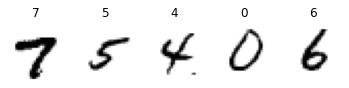

In [13]:
""" Apply any transformations:
shuffling, batching, prefetching."""

plt.figure(figsize=(6,3)) # from textbook notebook
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]

    # from textbook notebook
    # Plotting
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

> Note: `load()` function shuffles each data shard it downloads but may not be enough. So it's best to shuffle the training set some more.

In [14]:
"""Transform dataset from dictionary to tuple
using map() method."""

mnist_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [26]:
"""Ask load() function to transform dataset for you
by setting as_supervised=True."""

datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].prefetch(1)
model = keras.models.Sequential([
    # from textbook notebook
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              # Default "sgd" learning rate too small
              optimizer=keras.optimizers.SGD(lr=1e-3))
model.fit(mnist_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 40.8128
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 25.5163
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 24.3110
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 23.6515
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 23.4816
